In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Data prepcocessing

# Data download
We will create a dog vs cat classifier using transfer learning


In [2]:
# We're fetching the dataset from the Google Cloud Storage and creating the dataset directories

# Fetching the dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# Creating the dataset directories
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Setting up variables
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Importing the training and validation datasets into the codespace
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [3]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Inspecting the dataset
- Lets plot some cats and dogs to see what the images look like

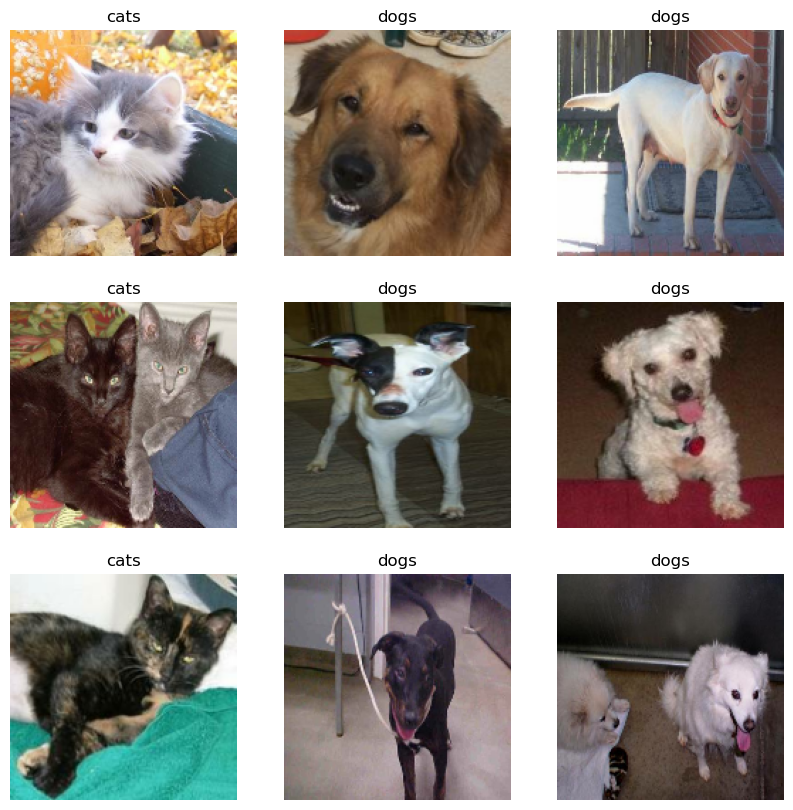

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10), facecolor='white')
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

    

Our dataset lacks a test set, so we will create one from the validation set. We will use tf.data.experimental.cardinality method to find out how many elements are in the validation set, then move 20% to a test set.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Configure the dataset for performance
Use buffered prefetching to load images from disk.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation
When a image dataset is small, we often want to artificially augment our dataset by applying yet random transformations to our data, such as flipping and rotating. This helps expose our model to more aspects of the data and generalize better aswell as minimizing overfitting.

**Note:** These layers are only active during training when you call model.fit. They are inactive when the model is used in inference mode in model.evaluate or model.call.

In [8]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(
    'horizontal'), tf.keras.layers.RandomRotation(0.2),])

Lets apply these layers to the same image a few times and inspect

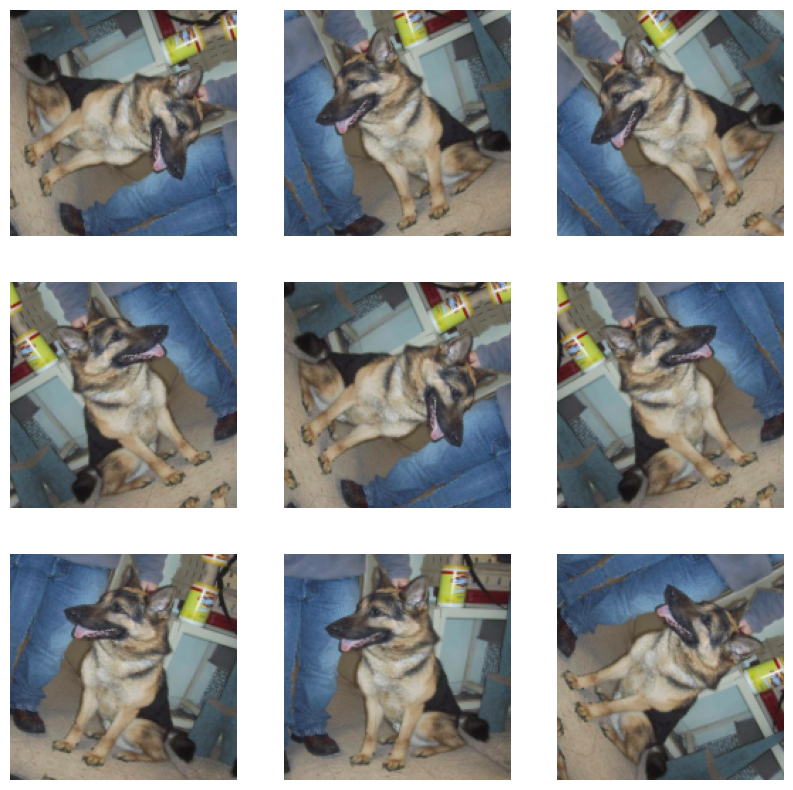

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Rescale pixel values

We will soon download our model, MobileNetV2 as a base model. The model expects pixel values in [-1,1], but at this point our pizels are in [0,255]. To rescale them we use a preprocessing method included with the model.

** You could also rescale manually or with tf.keras.layers.rescaling

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the base model from the pre-trained model MobileNet V2

We will create the base model MobileNetV2. This is pretrained on ImageNet, and has a lot of power.

- Pick which layers in MobileNet V2 we will use for feature extraction. The very last classification layer is pretty worthless for our purposes so we will not include it. (It classifies things into specific classes that MobileNet V2 is trained on, way to many for us, we only care about cats and dogs).
- We will follow common practice and depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.
- Load in the MobileNet V2 model preloaded with weights. Specify include_top = false so that we won't include the classification layers.

In [11]:
# Create the base model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Lets see what it does to an example batch of images.

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Feature extraction
In this step we will freeze the convolutional base created from the previous step to use as a feature extractor. We will also add a classifier on top of it and train the new classifier.

## Freeze the convolutional base

We will start with freezing the convolutional base, so that we don't have to retrain it.

In [13]:
base_model.trainable = False

## Inspect the "finished" base model 

In [14]:
# Inspect the base model
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

# Add classification head
We need to add a classifier to train on our cats and dogs on top of the pretrained base model. We will start with an average over the 5x5 layer. To convert the features into a single 1280-element vector per image.

In [17]:
# We convert our 5x5 feature maps to 1x1 feature vectors (one value per feature), by taking the average value for the entire map similar to maxpooling.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Create a dense layer to convert these features into a single prediction per image. 

In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


## Putting together the model
We will chain all the steps: data augmentation, rescaling, base model and classifier to build the model. We set training = false in the base model, because it contains batch normalization

In [19]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

The parameters in MobileNet are frozen, but the parameters in the Dense layer are trainable. These are divided between the two tf.variable objects, weights and biases.

In [22]:
# The 2 trainable variables are weights and biases of the last layer
len(model.trainable_variables)

2

In [23]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

## Train the model

In [24]:
# Evaluate the model on the test data without training, and chech the accuracy
initial_epoch = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 17s 451ms/step - loss: 0.8468 - accuracy: 0.4171


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.42


In [ ]:
# Train the actual model
history = model.fit(train_dataset, epochs=initial_epoch, validation_data=validation_dataset)